In [242]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import struct
import sys
from array import array
import itertools
import os
import sys
from scipy import signal
from scipy.optimize import curve_fit
import subprocess
import shutil

pi = np.pi
clight = 299792458

In [243]:
working_folder = 'eSR/2RF/'
home = os.getcwd()
cwd = os.path.join(home,working_folder)

In [245]:
inputfile = 'input.txt'
inputfile = os.path.join(cwd,inputfile)
tempinput = {}
with open(inputfile) as inputfile:
    for line in inputfile:
        if len(line.split())>1:
            tempinput[line.split()[0]] = line.split()[1:]
for i in tempinput:
    for j in range(len(tempinput[i])):
        tempinput[i][j] = float(tempinput[i][j])

In [246]:
nRF = int(tempinput['nRF'][0])
nRF1 = int(tempinput['nRF1'][0])
nRF2 = int(tempinput['nRF2'][0])
nRFc = int(tempinput['nRFc'][0])

E0Au = 196.9665687*931.5e6
E0Elec = 0.51099895000e6
nTurns = int(tempinput['n_turns'][0])
nfill = int(tempinput['n_fill'][0])
n_q_ramp = int(tempinput['n_q_ramp'][0])
NpRF = int(tempinput['N_bins'][0])
h = [int(i) for i in tempinput['h']]
detune_ini = np.array([i for i in tempinput['detune_ini']])
detune_final = np.array([i for i in tempinput['detune_final']])

step = int(tempinput['step_store'][0])
fill_step = int(tempinput['fill_step'][0])
nBeam = int(tempinput['nBeam'][0])
beam_shift = int(tempinput['beam_shift'][0])
nBunch = int(tempinput['n_bunches'][0])
nPar = int(tempinput['Npar'][0])
NperBunch = int(tempinput['NperBunch'][0])
nTot = nBunch*nPar*nBeam
Gamma0 = tempinput['Gamma'][0]
Rring = tempinput['R'][0]
n_record = nTurns/step
clight = 299792458
beta = np.sqrt(1-1/Gamma0**2)
T0 = 2*np.pi*Rring/(clight*beta)
f0 = 1/T0
V0 = [i for i in tempinput['Vref_I']]
V0Q = [i for i in tempinput['Vref_Q']]
II = [i for i in tempinput['Iref_I']]
IQ = [i for i in tempinput['Iref_Q']]
mainRF = int(tempinput['mainRF'][0])
if int(tempinput['type'][0]==2):
    atomicZ = 79
    Ek = Gamma0*E0Au
else:
    atomicZ =1
if int(tempinput['type'][0]==1):  
    Ek = Gamma0*E0Elec
    
GMTSQ = tempinput['GMTSQ'][0]
Ek_damp = tempinput['Ek_damp'][0]

eta = 1/GMTSQ-1/Gamma0**2
Qs = np.sqrt(h[mainRF]*atomicZ*np.abs(V0[mainRF]+V0[1])*eta/(2*np.pi*Ek))

omegarf = 2*np.pi*(np.array(h)*f0)
omegac = 2*np.pi*(np.array(h)*f0+detune_final)
Trf = 2*np.pi/omegarf
RoQ = [i for i in tempinput['RoQ']]
QL = [i for i in tempinput['QL']]
R = [RoQ[i]*QL[i] for i in range(nRF)]

Th = 2*np.pi/omegarf[0]
dthat =Th/NpRF

pattern = 'd'+'dd'*nBeam+3*nRF*'d'
n_stride = 1+2*nBeam+3*nRF
stride = len(pattern)*8
test = array('d')
bucket_height = 2*Qs/(h[mainRF]*eta)*Gamma0

print(bucket_height)
print(Ek)
print(Qs)

269.57032772928807
10015579420.0
0.05409826550710491


In [247]:
# arguments
ParType = 1 # 0 means proton, 1 means electron, 2 means gold

mainRF = 0
main_detune = 0
detune_slow_factor = 1

nTurn = 20000
step_store = 100
n_dynamic = 3000

n_fill = 3000
n_q_ramp = 15000
n_detune_start = 3000
n_detune_ramp = 18000
n_detune_ramp_tot = 18000 # last turn of detuning process
n_I_ramp_start = 3000
n_I_ramp_end = 18000

R_ring = 610.1754 
GMTSQ = 961.0 
Gamma0 = 19600.0 


t_rad_long = 0.05486 


nRF = 2
nRF1 = 2.0 
nRFc = 0.0 
nRF2 = 0.0 

nCav = 14.0
h = 7560.0 
RoQ = 73 # RoQ per cavity
gII = 1.0 
gQQ = 1.0 
nBunch = 1260
nPar0 = 17.2e10
Prad0 = 10e6

nPar = 17.2e10
Prad = Prad0*nPar/nPar0


N_macro = 1
nBins = 33
NC = nCav
NF = 9
ND = NC-NF
V0 = 23.7e6/NC
# with beam, with drive, with detune.
Urad0 = Prad/(nBunch*nPar*1.6e-19*f0) # radiation caused Voltage total
U_loss = Urad0/NC+2*pi*h*f0*RoQ*NC/4*nPar*1.6e-19 # loss per cavity
Vtot = 23.7e6 # total voltage 
Vquard = V0*np.sin(np.arccos(U_loss/V0))

Phis = np.arctan(Vquard/U_loss)+90/180*pi #171/180*pi            # synchronous phase in pCDR, in sin(wt+phis) convention. 
PhisNew = Phis-pi            # convert it to the phase used in my code, where I put the bunch at Trf/2, so we should subtract 'pi' from it.
                             # but this is still the phase for sin convention, to convert it so that can be used in my I Q calculation, need to 
                             # subtract another pi/2
PhisPhasor = Phis-pi/2
Vsynch_need = V0*np.sin(Phis)
Vquard_need = V0*np.cos(Phis)

Vnew = np.sqrt(Vsynch_need**2+(NC/(NF-ND)*Vquard_need)**2) # new cavity voltage per cavity, assuming the new phiSynch are the same (different sign) between two types of cavity
# new synchronous phase if we change the number of focusing and defocusing cavity.
PhisPhasorNew = np.arctan(NC/(NF-ND)*np.tan(PhisPhasor))
PhisNew = PhisPhasorNew+pi/2
####################################
# Important convert
####################################
PhiIQ = PhisNew-pi/2-pi
Pbeam0 = Prad0/NC # beam power per cavity

Pbeam = Prad0*nPar/nPar0/NC # beam power per cavity
RoQacc = RoQ*2
IbDC = nBunch*nPar*1.6021766208e-19*f0
f = 7560*f0

Qbeam0 = Vnew**2/(RoQacc*Pbeam0)
Qbeam = Vnew**2/(RoQacc*Pbeam)
#Qbeam = Qbeam0

Rsh = RoQ*Qbeam

tgPhi = np.abs(RoQ*Qbeam*IbDC*2*np.cos(Phis)/Vnew)
delta_f = f-f*(tgPhi/2/Qbeam+np.sqrt((tgPhi/2/Qbeam)**2+1))#-f*tgPhi/2/Qbeam

V_IF = -Vnew*NF*np.sin(PhiIQ)
V_QF = Vnew*NF*np.cos(PhiIQ)
V_ID = -Vnew*ND*np.sin(PhiIQ)
V_QD = Vnew*ND*np.cos(PhiIQ)

I_I = -2*IbDC*(tgPhi+np.tan(PhisPhasorNew))/tgPhi*np.cos(PhisPhasorNew)*np.sin(PhiIQ) # becareful not to forget the factor of '2'
I_Q = 2*IbDC*(tgPhi+np.tan(PhisPhasorNew))/tgPhi*np.cos(PhisPhasorNew)*np.cos(PhiIQ)
I_I_ini = -Vnew/(RoQ*Qbeam)*np.sin(PhiIQ)
I_Q_ini = Vnew/(RoQ*Qbeam)*np.cos(PhiIQ)

print("Vnew : ",Vnew)
print("QL : ",Qbeam)
print("Phis : ",Phis/pi*180, " [degree]")

print("PhisNew : ",PhisNew/pi*180, " [degree]")
print("PhisIQ : ",PhiIQ/pi*180, " [degree]")
print("Tan(PhisPhasor) : ",np.tan(PhisPhasor))
print("PhisPhasorNew : ",PhisPhasorNew/pi*180)

print("detune tan : ", tgPhi)
print("detune angle : ", np.arctan(tgPhi)/pi*180, " [degree]")
print("VIF : ",V_IF)
print("VQF : ",V_QF)
print("VID : ",V_ID)
print("VQD : ",V_QD)
print("II : ",I_I)
print("IQ : ",I_Q)
print("II_ini : ",I_I_ini)
print("IQ_ini : ",I_Q_ini)

print("Vsynch_need : ", Vsynch_need*NC)
print("Vsynch_new : ",Vnew*np.sin(PhisNew)*NC)
print("Vquard_need : ", Vquard_need*NC)
print("Vquard_new : ", Vnew*np.cos(PhisNew)*(NF-ND))
print("IbDC : ", IbDC)
print("delta_f : ",delta_f, " [Hz]")

Vnew :  5844864.892682732
QL :  327585.09492603544
Phis :  170.15164144390525  [degree]
PhisNew :  177.16046753309212  [degree]
PhisIQ :  -92.83953246690788  [degree]
Tan(PhisPhasor) :  5.76039131061746
PhisPhasorNew :  87.16046753309212
detune tan :  21.89024383819595
detune angle :  87.38440680816261  [degree]
VIF :  52539196.82608094
VQF :  -2605933.9172839774
VID :  29188442.68115608
VQD :  -1447741.0651577653
II :  0.5161434697948646
IQ :  -0.025600615452411858
II_ini :  0.2441146967654686
IQ_ini :  -0.012108041356521819
Vsynch_need :  4053674.982441756
Vsynch_new :  4053674.982441758
Vquard_need :  -23350754.144924864
Vquard_new :  -23350754.144924864
IbDC :  2.7151605921238295
delta_f :  -19752.026542901993  [Hz]


In [248]:
def Zparallel(Rsh, QL, omega0, omega):
    return Rsh*omega/(omega+1j*QL*(omega0-omega**2/omega0)) # using the convention from A. Chao's book

In [249]:
# Small tune shift approximation
r0 = (1*1.6021766208e-19)**2/(1*9.10938356e-31*3e8*3e8)

pmax = 1*nBunch # number of frequency samples 

mus = np.array([i*1259 for i in range(2)])#200#h[0]%nBunch # 
delta_omega_Re = np.zeros(nBunch)
delta_omega_Im = np.zeros(nBunch)
i=0
#print('Mode #, ','Delta_Omega_Re, ','Delta_Omega_Im', 'Growth_Time')
for mu in mus:
    ps = np.array([float(i) for i in range(-pmax,pmax+1)])
    ps[pmax]=0 # get rid of the zero point to avoid 1/0 problem in python

    # for the calculation of real part of Omega
    p_M_omega0 = ps*nBunch*2*np.pi*f0
    Zs0 = np.array([Zparallel(R[i],QL[i],omegac[i],p_M_omega0) for i in range(nRF)])
    factor1 = nBunch*NperBunch*r0*eta/(2*Gamma0*T0**2*Qs*f0*2*np.pi)
    delta_omegas = 0*factor1*np.sum(p_M_omega0*np.imag(Zs0)) # this is zero if optimumly compensated 
    omegas = Qs*2*pi*f0+delta_omegas

    omegas1 = ((ps*nBunch+mu)*2*np.pi*f0+omegas)
    Zs1 = np.array([Zparallel(R[i],QL[i],omegac[i],omegas1) for i in range(nRF)])
    factor1 = nBunch*NperBunch*r0*eta/(2*Gamma0*T0**2*omegas)
    deltaOmegaRe = -factor1*np.sum(omegas1*np.imag(Zs1))

    # for the calculation of the imaginary part of Omega
    omegas2 = ((ps*nBunch+mu)*2*np.pi*f0+(omegas))

    factor2 = nBunch*NperBunch*r0*eta/(2*Gamma0*T0**2*(omegas))

    Zs2 = np.array([Zparallel(R[i],QL[i],omegac[i],omegas2) for i in range(nRF)])
    deltaOmegaIm = factor2*np.sum(omegas2*np.real(Zs2))
    delta_omega_Re[i] = deltaOmegaRe
    delta_omega_Im[i] = deltaOmegaIm
    print(mu,deltaOmegaRe+omegas,';',deltaOmegaIm, ';',1/deltaOmegaIm)
    i+=1


0 10074.2811172769 ; -201.0050396694201 ; -0.0049749996400320845
1259 23773.58063902186 ; 30.760256855923092 ; 0.03250948146122009


In [250]:
def F(Omega,ps,mu,nRF,R,QL,omegac,nBunch, NperBunch,r0,eta,Gamma0,T0,Qs,f0):
    omegasamp = ((ps*nBunch+mu)*2*np.pi*f0+Omega)
    Zs = np.array([Zparallel(R[i],QL[i],omegac[i],omegasamp) for i in range(nRF)])
    factor = nBunch*NperBunch*r0*eta/(Gamma0*T0**2)
    #print(factor)
    #for i in range(len(omegasamp)):
    #    print(omegasamp[i])
    #    print(Zs.T[i])
    #    print((omegasamp*Zs).T[i])
    
    #print("RHS :",1j*factor*np.sum(omegasamp*Zs))
    return Omega**2-(1j*factor*np.sum(omegasamp*Zs)+(Qs*f0*2*pi)**2)

def SolveOmega(Omega,ps,mu,nRF,R,QL,omegac,nBunch, NperBunch,r0,eta,Gamma0,T0,Qs,f0,maxIter,accu):
    nIter = 0
    # initial values
    OmegaR = np.real(Omega)
    OmegaI = np.imag(Omega)
    # step size
    sig1 = 1
    sig2 = 1*1j
    Err = F(Omega,ps,mu,nRF,R,QL,omegac,nBunch, NperBunch,r0,eta,Gamma0,T0,Qs,f0)
    
    Fre = np.real(Err)
    Fim = np.imag(Err)
    dF11 = np.real(F(Omega+sig1,ps,mu,nRF,R,QL,omegac,nBunch, NperBunch,r0,eta,Gamma0,T0,Qs,f0))-Fre
    dF12 = np.real(F(Omega+sig2,ps,mu,nRF,R,QL,omegac,nBunch, NperBunch,r0,eta,Gamma0,T0,Qs,f0))-Fre
    dF21 = np.imag(F(Omega+sig1,ps,mu,nRF,R,QL,omegac,nBunch, NperBunch,r0,eta,Gamma0,T0,Qs,f0))-Fim
    dF22 = np.imag(F(Omega+sig2,ps,mu,nRF,R,QL,omegac,nBunch, NperBunch,r0,eta,Gamma0,T0,Qs,f0))-Fim
    det = dF11*dF22-dF12*dF21
    dF11inv = dF22/det
    dF12inv = -dF12/det
    dF21inv = -dF21/det
    dF22inv = dF11/det
    
    OmegaR -= Fre*dF11inv+Fim*dF12inv
    OmegaI -= Fre*dF21inv+Fim*dF22inv
    Omega = OmegaR+OmegaI*1j
    #RHS = np.sqrt(1j*factor*np.sum(omegasamp*Zs)+(Qs*f0*2*pi)**2)
    #LHS = Omega
    
    while(np.abs(Err)>accu and nIter<maxIter):
        OmegaR = np.real(Omega)
        OmegaI = np.imag(Omega)    
        Err = F(Omega,ps,mu,nRF,R,QL,omegac,nBunch, NperBunch,r0,eta,Gamma0,T0,Qs,f0)
        F1 = F(Omega+sig1,ps,mu,nRF,R,QL,omegac,nBunch, NperBunch,r0,eta,Gamma0,T0,Qs,f0) # change OmegaRe by a small step
        F2 = F(Omega+sig2,ps,mu,nRF,R,QL,omegac,nBunch, NperBunch,r0,eta,Gamma0,T0,Qs,f0) # change OmegaIm by a small step
        Fre = np.real(Err)
        Fim = np.imag(Err)
        F1re = np.real(F1)
        F1im = np.imag(F1)
        F2re = np.real(F2)
        F2im = np.imag(F2)
        # approximate the Jacobian
        dF11 = F1re-Fre
        dF12 = F2re-Fre
        dF21 = F1im-Fim
        dF22 = F2im-Fim
        
        det = dF11*dF22-dF12*dF21
        #print(det)
        # inverse the Jacobian
        dF11inv = dF22/det
        dF12inv = -dF12/det
        dF21inv = -dF21/det
        dF22inv = dF11/det

        OmegaR -= Fre*dF11inv+Fim*dF12inv
        OmegaI -= Fre*dF21inv+Fim*dF22inv
        Omega = OmegaR+OmegaI*1j
        #print(Err)
        #print(Omega)
        nIter += 1
    return Omega
    print(Omega)
    print(np.abs(Err))
    print(nIter)

In [251]:
mus = [0]

In [252]:
detune_final

array([-20790.12735868,  19952.57740748])

In [253]:
(omegac-omegarf)/2/pi

array([-20790.12735868,  19952.57740749])

In [254]:
NperBunch

172000000000

In [255]:
R

[216247004.35831106, 120137224.64350615]

In [256]:
QL

[329143.08121508535, 329143.08121508535]

In [257]:
ps

array([-1260., -1259., -1258., ...,  1258.,  1259.,  1260.])

In [258]:
# Iterative solve:
Omega = Qs*f0*2*pi
temp = 0
delta_omega_Re_Iter = np.zeros(nBunch)
delta_omega_Im_Iter = np.zeros(nBunch)
idx = 0
for i in mus: #range(1260):#
    Omega = Qs*f0*2*pi
    temp = SolveOmega(Omega,ps,i,nRF,R,QL,omegac,nBunch, NperBunch,r0,eta,Gamma0,T0,Qs,f0,3000,1e-15)
    delta_omega_Re_Iter[idx] = np.real(temp)
    delta_omega_Im_Iter[idx] = np.imag(temp)
    idx+=1
    print(i,';',temp)

0 ; (-4.688533697506934e-13+11745.810075615886j)


In [241]:
nNpsamp = 2 # number of samples for the number of particles per bunch
nDetunesamp = 2 # number of samples for the detune.
nModes = 1#nBunch # number of modes we want to investigate.
nPar = np.ones(nNpsamp)
Rsh = R
Detune = np.ndarray(shape = (nDetunesamp,nRF))
omegac = np.ndarray(shape = (nDetunesamp,nRF))
R = np.ndarray(shape = (nNpsamp,nRF))
Qbeam = np.ndarray(shape = (nNpsamp,nRF))
DetuneMin = detune_final*2*pi*1
DetuneMax = -detune_final*2*pi*1

for i in range(nDetunesamp):
    for j in range(nRF):
        Detune[i][j] = (DetuneMin[j]+(DetuneMax[j]-DetuneMin[j])/(nDetunesamp-1)*i)/2/pi
        omegac[i][j] = omegarf[0]+DetuneMin[j]+(DetuneMax[j]-DetuneMin[j])/(nDetunesamp-1)*i

In [261]:
# the number of particles per bunch will change the potimized QL
# 
nPar0 = 17.2e10
for i in range(nNpsamp):
    nPar[i] = nPar0/nNpsamp*(i+1)
Prad0 = 9e6
Prad = Prad0*nPar/nPar0
RoQ = np.zeros(nRF)
for i in range(nRF):
    RoQ[i] = 73
RoQacc = RoQ*2
IbDC = nBunch*nPar*1.6e-19*f0
f = 7560*f0
NC = 14
Pbeam = Prad0*nPar/nPar0/NC # beam power per cavity
NF = 9
ND = NC-NF
V0 = 23.7e6/NC
# with beam, with drive, with detune.
Urad0 = Prad/(nBunch*nPar*1.6e-19*f0) # radiation caused Voltage
U_loss = Urad0+2*pi*f0*RoQ[0]*NC/4*nPar*1.6e-19
Vtot = 23.7e6 # total voltage 

Phis = np.arccos(U_loss/Vtot)+90/180*pi #171/180*pi            # synchronous phase in pCDR, in sin(wt+phis) convention. 
PhisNew = Phis-pi            # convert it to the phase used in my code, where I put the bunch at Trf/2, so we should subtract 'pi' from it.
                             # but this is still the phase for sin convention, to convert it so that can be used in my I Q calculation, need to 
                             # subtract another pi/2
PhisPhasor = Phis-pi/2
Vsynch_need = V0*np.sin(Phis)
Vquard_need = V0*np.cos(Phis)

Vnew = np.sqrt(Vsynch_need**2+(NC/(NF-ND)*Vquard_need)**2)


# get the total Rs for each type
for i in range(nNpsamp):
    Qbeam[i][0] = Vnew[i]**2/(RoQacc[0]*Pbeam[i])
    Qbeam[i][1] = Vnew[i]**2/(RoQacc[1]*Pbeam[i])
    R[i][0] = Qbeam[i][0]*NF*RoQ[0]
    R[i][1] = Qbeam[i][1]*ND*RoQ[1]
Idc = nPar*nBunch*f0*1.6e-19

In [262]:
OmegaRe = np.ndarray(shape=(nNpsamp,nDetunesamp,nModes), dtype='d')
OmegaIm = np.ndarray(shape=(nNpsamp,nDetunesamp,nModes), dtype='d')
pmax = 2*nBunch # number of samples 

ps = np.array([float(i) for i in range(-pmax,pmax)])
ps[pmax]=1e-16 # get rid of the zero point to avoid 1/0 problem in python
#mus = np.array([i for i in range(nModes)])#200#h[0]%nBunch # 
mus = np.array([1259*i for i in range(nModes)])#200#h[0]%nBunch # 


In [263]:
for i in range(nNpsamp):
    for j in range(nDetunesamp):
        for k in range(nModes):
            OmegaRe[i][j][k] = 0
            OmegaIm[i][j][k] = 0

In [264]:
paraSpace = np.ndarray(shape=(nNpsamp,nDetunesamp,3*nRF+1))
for i in range(nNpsamp):
    for j in range(nDetunesamp):
        for k in range(nRF):
            paraSpace[i][j][k] = 0

In [265]:
nOmega = 1
Omegas = np.zeros(nOmega)
temp = np.array([0+0*i*1j for i in range(nOmega)])
for i in range(nOmega):
    Omegas[i] = 1*Qs*f0*2*pi*np.exp(i/nOmega/360*2*pi)
stable = 1 # flag indicating stability, 0 mean instable.
for i in range(nNpsamp):
    for j in range(nDetunesamp):
        idx = 0
        for mu in mus:
            stable = 1
            idx2 = 0
            for Omega in Omegas:
                print(Omega/2/pi)
                temp[idx2] = SolveOmega(Omega,ps,mu,nRF,R[i],Qbeam[i],omegac[j],nBunch, nPar[i],r0,eta,Gamma0,T0,Qs,f0,1000,1e-9)
                idx2+=1
            OmegaIm[i][j][idx] = np.max(np.imag(temp))
            OmegaRe[i][j][idx] = np.real(temp[np.argmax(np.imag(temp))])
            idx+=1
    if int((i/nNpsamp)*100)%10==0:
        print(i/nNpsamp*100,'%')

4230.283569519259
1132223627.2257886
752693475.6546552
714579518.3370453
714083127.4395242
714083022.6938412
714083022.6936977
714083022.6935982
714083022.6943821
714083022.6935858
714083022.6943821
714083022.6935858
714083022.6943821
714083022.6935858
714083022.6943821
714083022.6935858
714083022.6943821
714083022.6935858
714083022.6943821
714083022.6935858
714083022.6943821
714083022.6935858
714083022.6943821
714083022.6935858
714083022.6943821
714083022.6935858
714083022.6943821
714083022.6935858
714083022.6943821
714083022.6935858
714083022.6943821
714083022.6935858
714083022.6943821
714083022.6935858
714083022.6943821
714083022.6935858
714083022.6943821
714083022.6935858
714083022.6943821
714083022.6935858
714083022.6943821
714083022.6935858
714083022.6943821
714083022.6935858
714083022.6943821
714083022.6935858
714083022.6943821
714083022.6935858
714083022.6943821
714083022.6935858
714083022.6943821
714083022.6935858
714083022.6943821
714083022.6935858
714083022.6943821
714083022

714083022.6943821
714083022.6935858
714083022.6943821
714083022.6935858
714083022.6943821
714083022.6935858
714083022.6943821
714083022.6935858
714083022.6943821
714083022.6935858
714083022.6943821
714083022.6935858
714083022.6943821
714083022.6935858
714083022.6943821
714083022.6935858
714083022.6943821
714083022.6935858
714083022.6943821
714083022.6935858
714083022.6943821
714083022.6935858
714083022.6943821
714083022.6935858
714083022.6943821
714083022.6935858
714083022.6943821
714083022.6935858
714083022.6943821
714083022.6935858
714083022.6943821
714083022.6935858
714083022.6943821
714083022.6935858
714083022.6943821
714083022.6935858
714083022.6943821
714083022.6935858
714083022.6943821
714083022.6935858
714083022.6943821
714083022.6935858
714083022.6943821
714083022.6935858
714083022.6943821
714083022.6935858
714083022.6943821
714083022.6935858
714083022.6943821
714083022.6935858
714083022.6943821
714083022.6935858
714083022.6943821
714083022.6935858
714083022.6943821
714083022.

3207805608.1533327
3207805608.1533327
3207805608.1533327
3207805608.1533327
3207805608.1533327
3207805608.1533327
3207805608.1533327
3207805608.1533327
3207805608.1533327
3207805608.1533327
3207805608.1533327
3207805608.1533327
3207805608.1533327
3207805608.1533327
3207805608.1533327
3207805608.1533327
3207805608.1533327
3207805608.1533327
3207805608.1533327
3207805608.1533327
3207805608.1533327
3207805608.1533327
3207805608.1533327
3207805608.1533327
3207805608.1533327
3207805608.1533327
3207805608.1533327
3207805608.1533327
3207805608.1533327
3207805608.1533327
3207805608.1533327
3207805608.1533327
3207805608.1533327
3207805608.1533327
3207805608.1533327
3207805608.1533327
3207805608.1533327
3207805608.1533327
3207805608.1533327
3207805608.1533327
3207805608.1533327
3207805608.1533327
3207805608.1533327
3207805608.1533327
3207805608.1533327
3207805608.1533327
3207805608.1533327
3207805608.1533327
3207805608.1533327
3207805608.1533327
3207805608.1533327
3207805608.1533327
3207805608.1

3207805608.1533327
3207805608.1533327
3207805608.1533327
3207805608.1533327
3207805608.1533327
3207805608.1533327
3207805608.1533327
3207805608.1533327
3207805608.1533327
3207805608.1533327
3207805608.1533327
3207805608.1533327
3207805608.1533327
3207805608.1533327
3207805608.1533327
3207805608.1533327
3207805608.1533327
3207805608.1533327
3207805608.1533327
3207805608.1533327
3207805608.1533327
3207805608.1533327
3207805608.1533327
3207805608.1533327
3207805608.1533327
3207805608.1533327
3207805608.1533327
3207805608.1533327
3207805608.1533327
3207805608.1533327
3207805608.1533327
3207805608.1533327
3207805608.1533327
3207805608.1533327
3207805608.1533327
3207805608.1533327
3207805608.1533327
3207805608.1533327
3207805608.1533327
3207805608.1533327
3207805608.1533327
3207805608.1533327
3207805608.1533327
3207805608.1533327
3207805608.1533327
3207805608.1533327
3207805608.1533327
3207805608.1533327
3207805608.1533327
3207805608.1533327
3207805608.1533327
3207805608.1533327
3207805608.1

In [266]:
OmegaIm

array([[[  -41.94158194],
        [   46.48990587]],

       [[18381.68814877],
        [  191.62502694]]])

In [226]:
OmegaRe/2/pi

array([[[ 2.09122238e+03],
        [ 4.58978030e+03]],

       [[-2.34040561e-09],
        [ 4.93285315e+03]]])

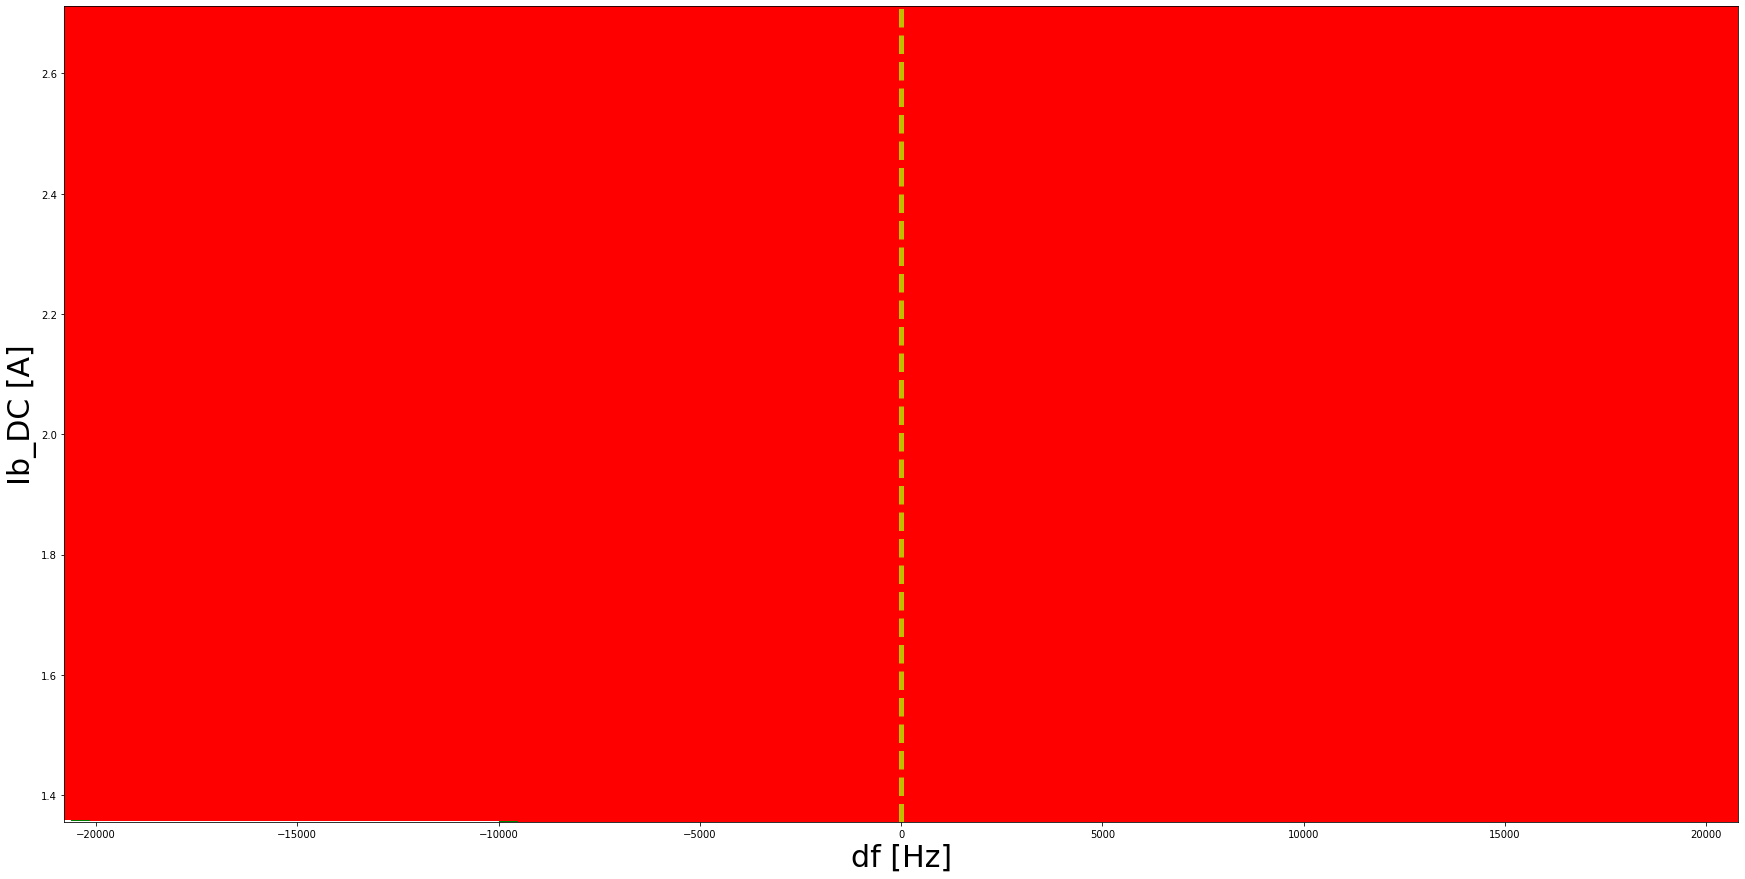

In [223]:
fig1,axes1 = plt.subplots(1,1)
axes1.contourf(Detune[:,0],Idc,OmegaIm[:,:,0],levels=[-1,0,1e5,1e60],colors=['g','r','b'])

axes1.axvline(x = 0,linewidth = 5,color='y',linestyle='--')
fig1.set_figheight(15)
fig1.set_figwidth(30)
axes1.set_ylabel('Ib_DC [A]',fontsize=30)
axes1.set_xlabel('df [Hz]',fontsize=30)

fn_stab = os.path.join(cwd,'stability_map_mu_0.jpg')
plt.savefig(fn_stab,bbox_inches='tight')
plt.show()


IndexError: index 1 is out of bounds for axis 2 with size 1

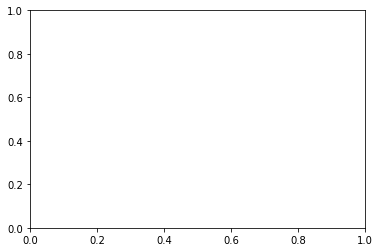

In [198]:
fig1,axes1 = plt.subplots(1,1)
axes1.contourf(Detune[:,0],Idc,OmegaIm[:,:,1],levels=[-100,0,100],colors=['g','r','b'])
#-Qs/5/T0-1/t_rad_long
axes1.axvline(x = 0,linewidth = 1,linestyle='--')
fig1.set_figheight(15)
fig1.set_figwidth(30)
axes1.set_ylabel('Ib_DC [A]',fontsize=30)
axes1.set_xlabel('df [Hz]',fontsize=30)

fn_stab = os.path.join(cwd,'stability_map_mu_1259.jpg')
plt.savefig(fn_stab,bbox_inches='tight')
plt.show()


In [222]:
-Qs/5/T0-1/t_rad_long

-864.2939282502513

In [219]:
Qs

0.054098840794387586

In [220]:
T0

1.27883307627183e-05

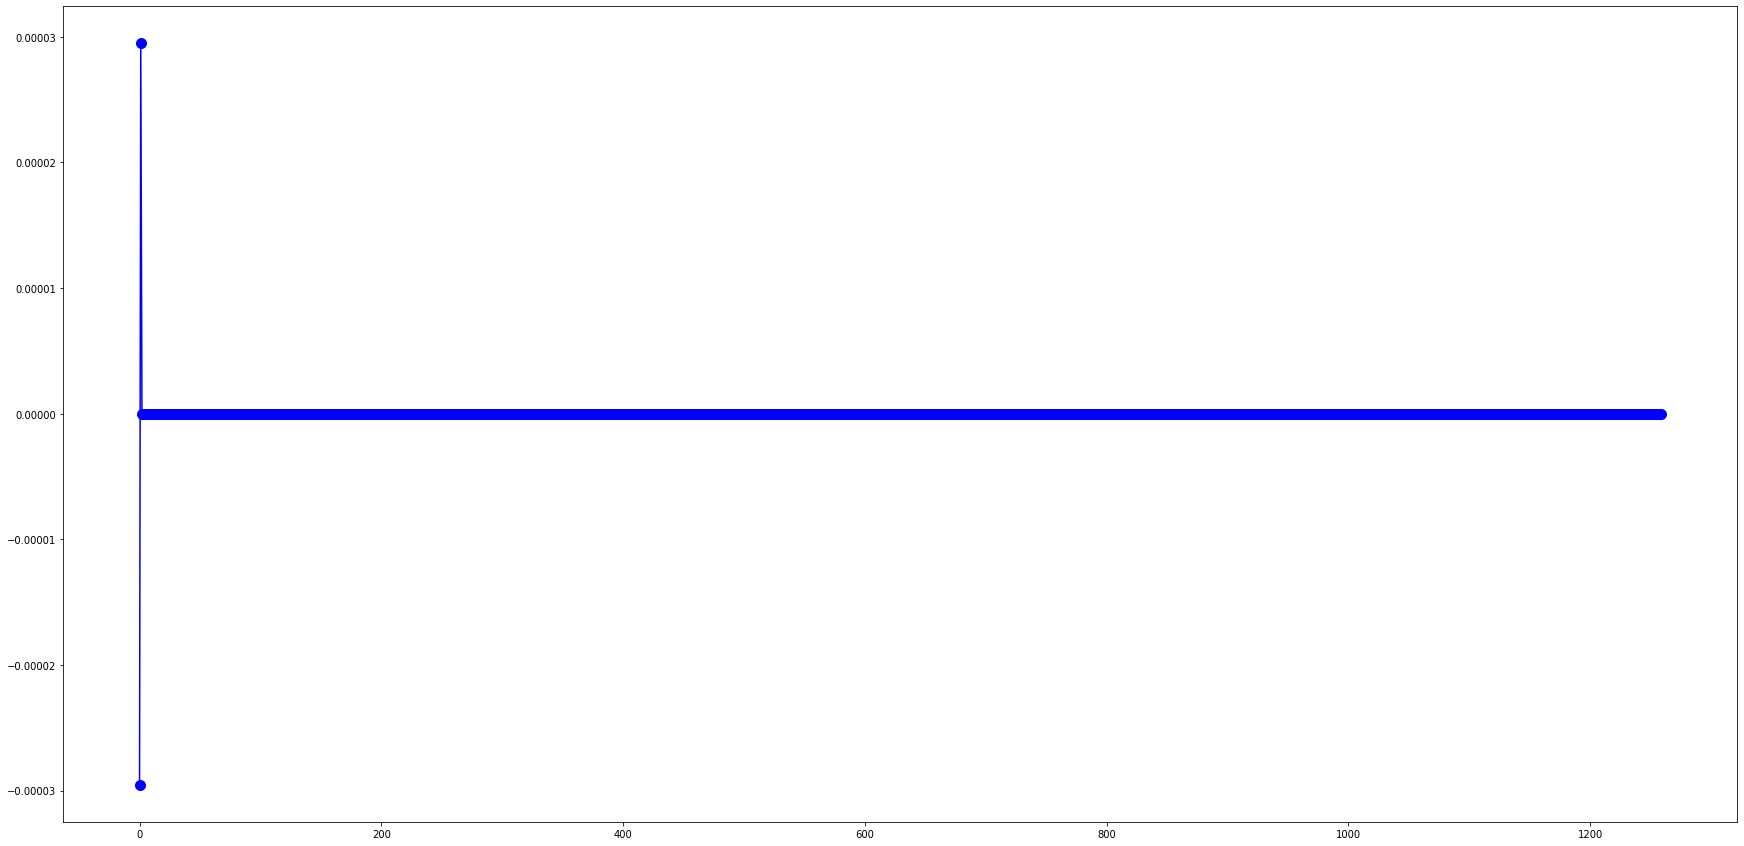

In [13]:
fig1,axes1 = plt.subplots(1,1)
axes1.plot((delta_omega_Im_Iter),'b.-',ms=20)

#axes1.set_ylim([1e4,1e5])
#axes1.set_ylim([-1e-3,1e-3])

fig1.set_figheight(15)
fig1.set_figwidth(30)

plt.show()

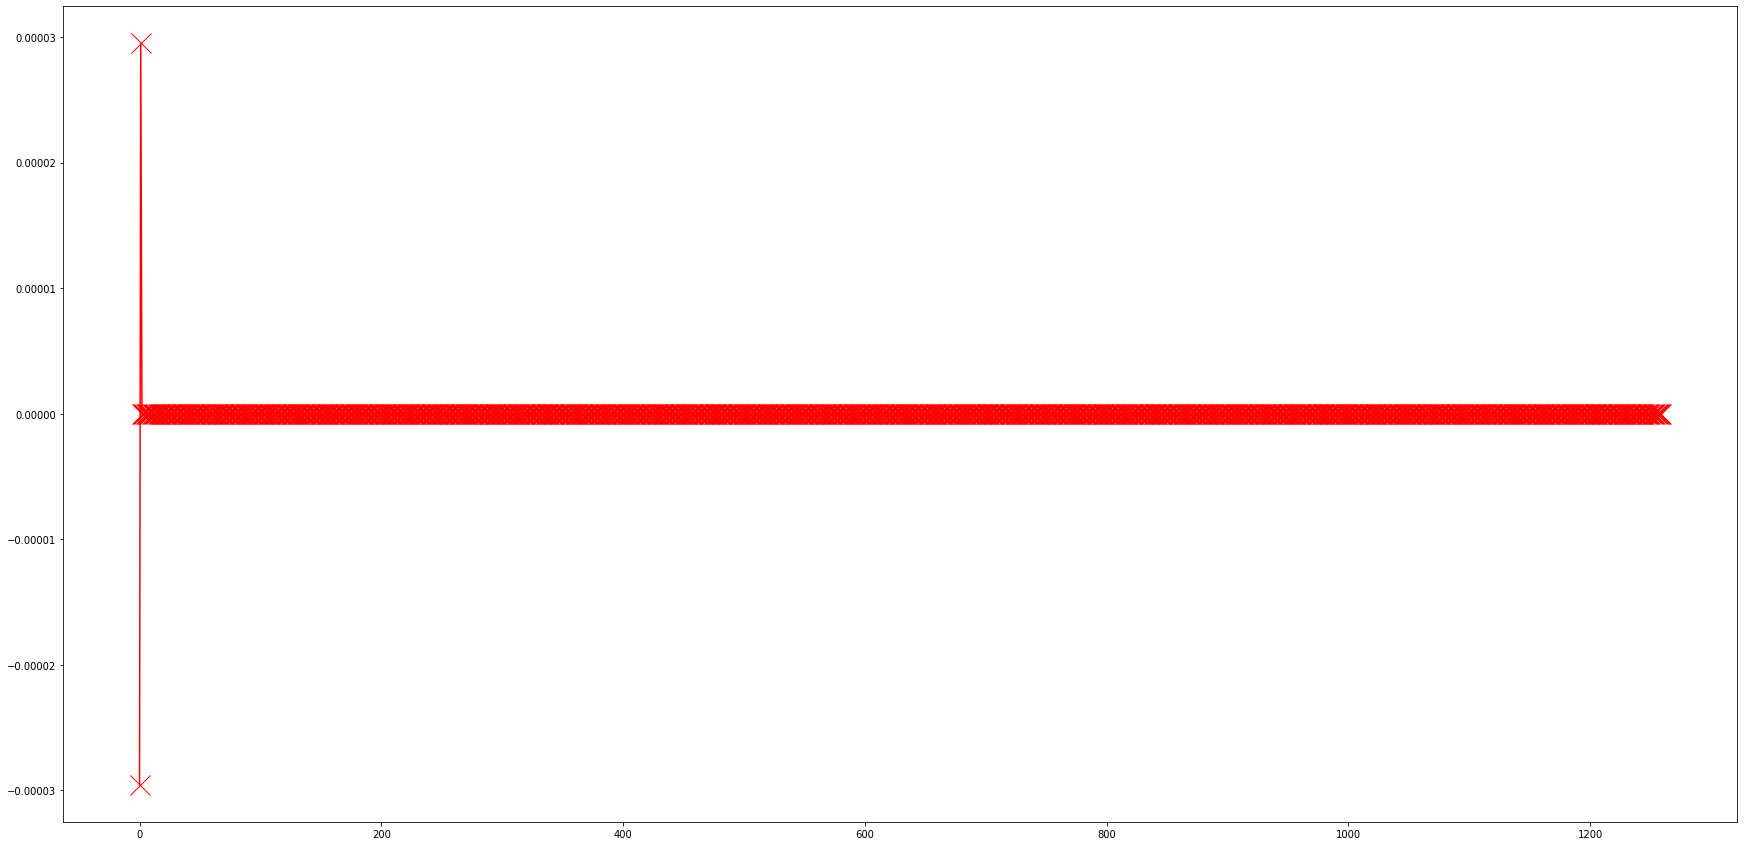

In [14]:
fig1,axes1 = plt.subplots(1,1)
axes1.plot((delta_omega_Im),'rx-',ms=20)

#axes1.set_ylim([1e4,1e5])
#axes1.set_ylim([-1e-6,1e-6])

fig1.set_figheight(15)
fig1.set_figwidth(30)

plt.show()

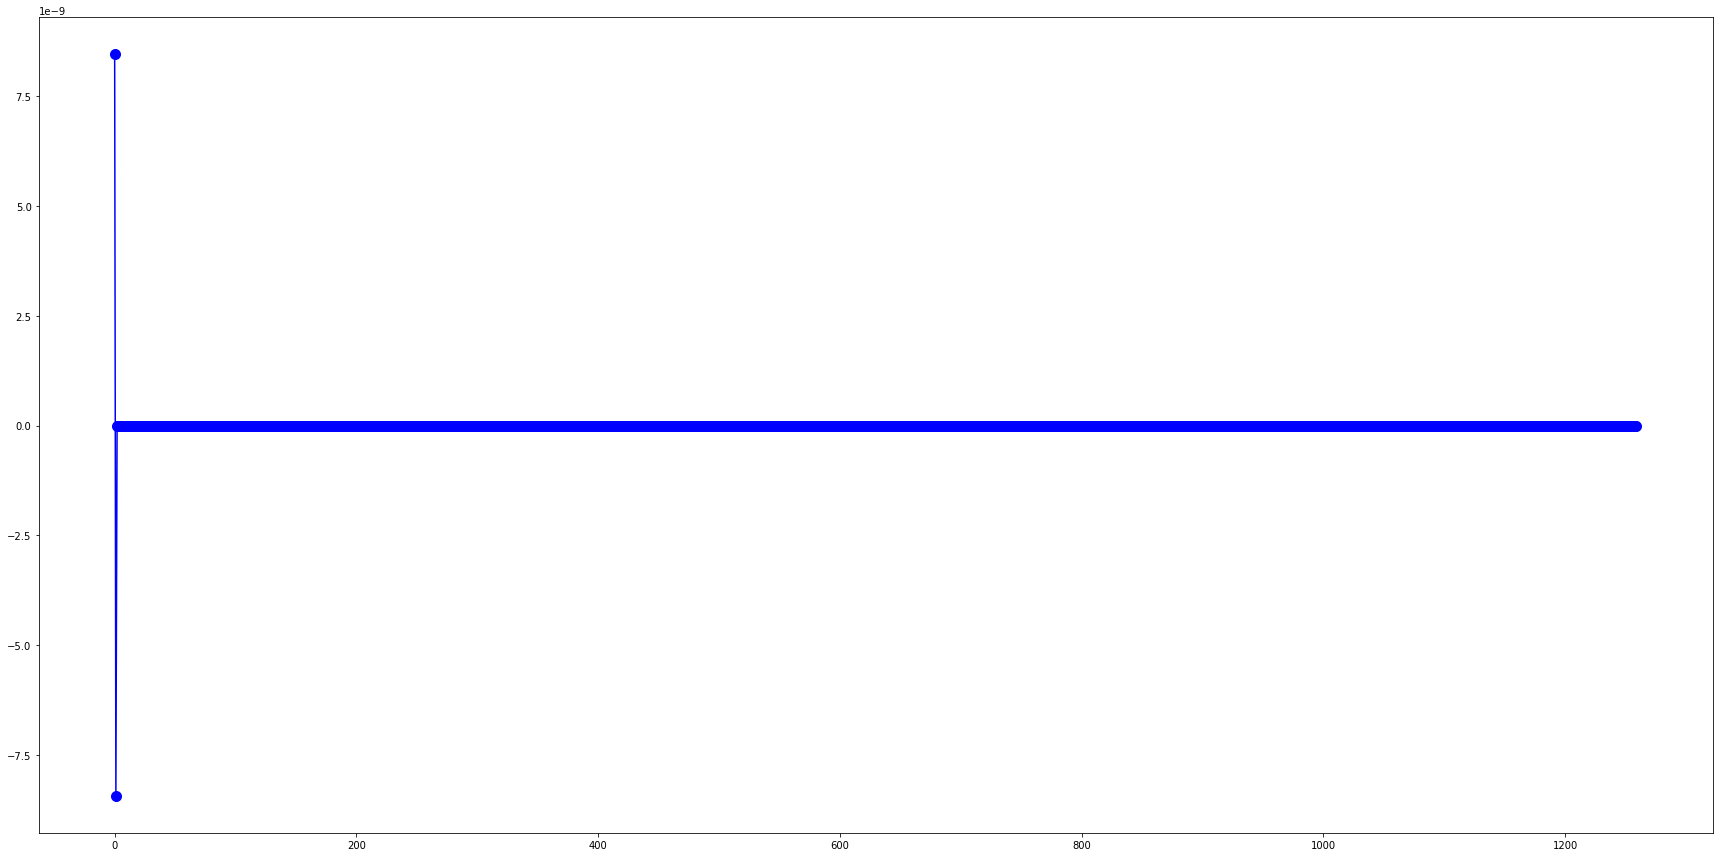

In [15]:
fig1,axes1 = plt.subplots(1,1)
#axes1.plot((delta_omega_Im),'rx-',ms=20)
axes1.plot((delta_omega_Im_Iter-delta_omega_Im),'b.-',ms=20)

#axes1.set_ylim([1e4,1e5])
#axes1.set_ylim([-1e-6,1e-6])

fig1.set_figheight(15)
fig1.set_figwidth(30)

plt.show()

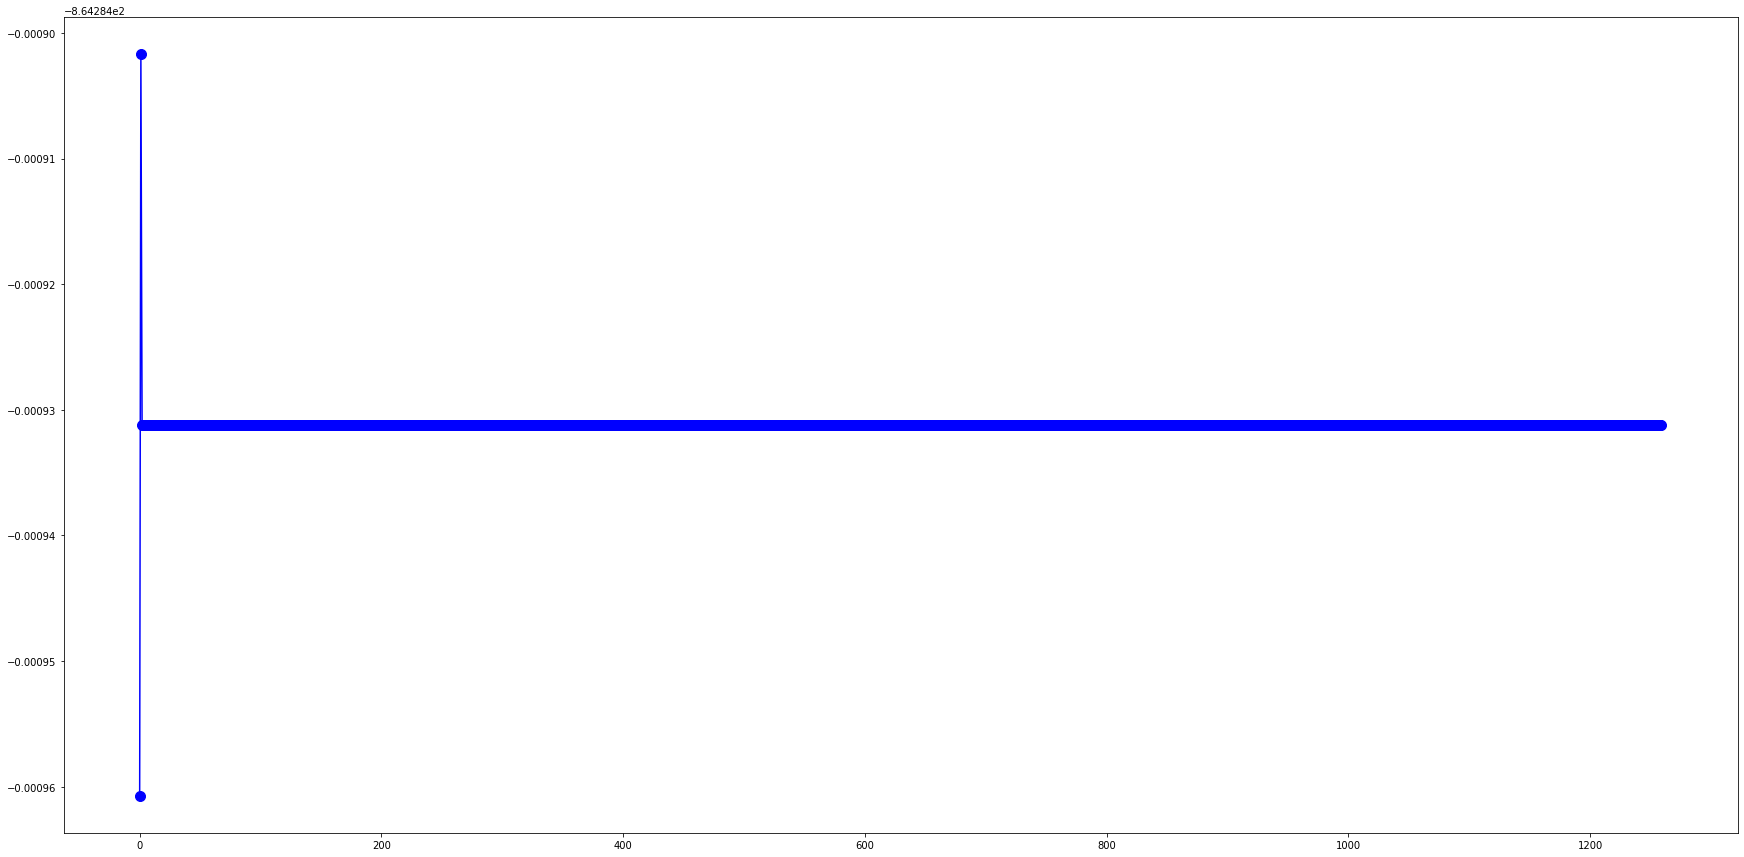

In [16]:
fig1,axes1 = plt.subplots(1,1)
axes1.plot((delta_omega_Im_Iter-Qs/5/T0-1/t_rad_long),'b.-',ms=20)
#axes1.set_ylim([-1e-3,1e-3])

fig1.set_figheight(15)
fig1.set_figwidth(30)

plt.show()

In [154]:
# Stable Zone is too small !!

Debug Zone

In [233]:
OmegaIm[0,:,1]

array([ 7.35705842e-04,  7.31872893e-04,  7.28041912e-04,  7.24212890e-04,
        7.20385815e-04,  7.16560676e-04,  7.12737464e-04,  7.08916166e-04,
        7.05096773e-04,  7.01279274e-04,  6.97463658e-04,  6.93649913e-04,
        6.89838031e-04,  6.86027999e-04,  6.82219807e-04,  6.78413444e-04,
        6.74608901e-04,  6.70806165e-04,  6.67005227e-04,  6.63206076e-04,
        6.59408702e-04,  6.55613093e-04,  6.51819239e-04,  6.48027130e-04,
        6.44236755e-04,  6.40448103e-04,  6.36661165e-04,  6.32875929e-04,
        6.29092384e-04,  6.25310522e-04,  6.21530330e-04,  6.17751799e-04,
        6.13974917e-04,  6.10199676e-04,  6.06426063e-04,  6.02654069e-04,
        5.98883684e-04,  5.95114896e-04,  5.91347696e-04,  5.87582073e-04,
        5.83818017e-04,  5.80055517e-04,  5.76294563e-04,  5.72535144e-04,
        5.68777251e-04,  5.65020874e-04,  5.61266000e-04,  5.57512621e-04,
        5.53760727e-04,  5.50010306e-04,  5.46261348e-04,  5.42513844e-04,
        5.38767783e-04,  

In [156]:
Omega = 1*Qs*f0*2*pi
temp = SolveOmega(Omega,ps,0,nRF,R[99],Qbeam[99],omegac[165],nBunch, nPar[99],r0,eta,Gamma0,T0,Qs,f0,1000,1e-9)
print(temp)

(35600.10419163463-1643.2000325866557j)


In [157]:
def SolveOmegaDebug(Omega,ps,mu,nRF,R,QL,omegac,nBunch, NperBunch,r0,eta,Gamma0,T0,Qs,f0,maxIter,accu):
    nIter = 0
    omegasamp = ((ps*nBunch+mu)*2*np.pi*f0+Omega)
    Zs = np.array([Zparallel(R,QL,omegac,omegasamp) for i in range(nRF)])
    factor = nBunch*NperBunch*r0*eta/(Gamma0*T0**2)
    RHS = np.sqrt(1j*factor*np.sum(omegasamp*Zs)+(Qs*f0*2*pi)**2)
    LHS = Omega
    ErrRe = np.real(LHS-RHS)
    ErrIm = np.imag(LHS-RHS)
    while(np.sqrt(ErrRe**2+ErrIm**2)>accu and nIter<maxIter):
        omegasamp = ((ps*nBunch+mu)*2*np.pi*f0+Omega)
        Zs = np.array([Zparallel(R,QL,omegac,omegasamp) for i in range(nRF)])
        factor = nBunch*NperBunch*r0*eta/(Gamma0*T0**2)
        RHS = np.sqrt(1j*factor*np.sum(omegasamp*Zs)+(Qs*f0*2*pi)**2)
        LHS = Omega
        ErrRe = np.real(LHS-RHS)
        ErrIm = np.imag(LHS-RHS)
        Omega-=ErrRe*1+ErrIm*1j
        nIter+=1
    return Omega   
    print(Omega)
    print((ErrRe))
    print((ErrIm))
    print(nIter)


In [158]:
Iidx = 99
Omegaidx = 165
Omega = 1*Qs*f0*2*pi
temp = SolveOmegaDebug(Omega,ps,0,nRF,R[Iidx],Qbeam[Iidx],omegac[Omegaidx],nBunch, nPar[Iidx],r0,eta,Gamma0,T0,Qs,f0,1000,1e-19)
print(temp)

ValueError: operands could not be broadcast together with shapes (2,) (200,) 

In [ ]:
# Small tune shift approximation
r0 = (1*1.6e-19)**2/(1*9.10938356e-31*3e8*3e8)

pmax = 100#1*nBunch # number of samples 

mus = np.array([i for i in range(1)])#200#h[0]%nBunch # 
delta_omega_Re = np.zeros(nBunch)
delta_omega_Im = np.zeros(nBunch)
i=0
#print('Mode #, ','Delta_Omega_Re, ','Delta_Omega_Im', 'Growth_Time')
for mu in mus:
    ps = np.array([float(i) for i in range(-pmax,pmax)])
    ps[pmax]=1e-16 # get rid of the zero point to avoid 1/0 problem in python

    # for the calculation of real part of Omega
    p_M_omega0 = ps*nBunch*2*np.pi*f0
    Zs0 = np.array([Zparallel(R[Iidx],Qbeam[Iidx],omegac[Omegaidx],p_M_omega0) for i in range(nRF)])
    factor1 = nBunch*nPar[Iidx]*r0*eta/(2*Gamma0*T0**2*Qs*f0*2*np.pi)
    delta_omegas = 0*factor1*np.sum(p_M_omega0*np.imag(Zs0)) # this is zero if optimumly compensated 
    omegas = Qs*2*pi*f0+delta_omegas

    omegas1 = ((ps*nBunch+mu)*2*np.pi*f0+omegas)
    Zs1 = np.array([Zparallel(R[Iidx],Qbeam[Iidx],omegac[Omegaidx],omegas1) for i in range(nRF)])
    factor1 = nBunch*nPar[Iidx]*r0*eta/(2*Gamma0*T0**2*omegas)
    deltaOmegaRe = -factor1*np.sum(omegas1*np.imag(Zs1))

    # for the calculation of the imaginary part of Omega
    omegas2 = ((ps*nBunch+mu)*2*np.pi*f0+(omegas))

    factor2 = nBunch*nPar[Iidx]*r0*eta/(2*Gamma0*T0**2*(omegas))

    Zs2 = np.array([Zparallel(R[Iidx],Qbeam[Iidx],omegac[Omegaidx],omegas2) for i in range(nRF)])
    deltaOmegaIm = factor2*np.sum(omegas2*np.real(Zs2))
    delta_omega_Re[i] = deltaOmegaRe+omegas
    delta_omega_Im[i] = deltaOmegaIm
    print(i,deltaOmegaRe+omegas,';',deltaOmegaIm, ';',1/deltaOmegaIm)
    i+=1


In [ ]:
def SolveOmega(Omega,ps,mu,nRF,R,QL,omegac,nBunch, NperBunch,r0,eta,Gamma0,T0,Qs,f0,maxIter,accu):
    nIter = 0
    # initial values
    OmegaR = np.real(Omega)
    OmegaI = np.imag(Omega)
    # step size
    sig1 = 1
    sig2 = 1
    
    omegasamp = ((ps*nBunch+mu)*2*np.pi*f0+Omega)
    Zs = np.array([Zparallel(R,QL,omegac,omegasamp) for i in range(nRF)])
    factor = nBunch*NperBunch*r0*eta/(Gamma0*T0**2)
    F = Omega-(1j*factor*np.sum(omegasamp*Zs)+(Qs*f0*2*pi)**2)
    RHS = np.sqrt(1j*factor*np.sum(omegasamp*Zs)+(Qs*f0*2*pi)**2)
    LHS = Omega
    ErrRe = np.real(LHS-RHS)
    ErrIm = np.imag(LHS-RHS)
    while(np.sqrt(ErrRe**2+ErrIm**2)>accu and nIter<maxIter):
        omegasamp = ((ps*nBunch+mu)*2*np.pi*f0+Omega)
        Zs = np.array([Zparallel(R,QL,omegac,omegasamp) for i in range(nRF)])
        factor = nBunch*NperBunch*r0*eta/(Gamma0*T0**2)
        RHS = np.sqrt(1j*factor*np.sum(omegasamp*Zs)+(Qs*f0*2*pi)**2)
        LHS = Omega
        ErrRe = np.real(LHS-RHS)
        ErrIm = np.imag(LHS-RHS)
        Omega-=ErrRe*1+ErrIm*1j
        nIter+=1
    return Omega

    print(Omega)
    print((ErrRe))
    print((ErrIm))
    print(nIter)


In [176]:
NC = 14
NF = 9
ND = NC-NF
V0 = 23.7e6/NC
Prad = 10e6
nPar = 17.2e10
# with beam, with drive, with detune.
Urad0 = Prad/(nBunch*nPar*1.6021766208e-19*f0) # radiation caused Voltage total
U_loss = Urad0/NC #+2*pi*h*f0*RoQ*NC/4*nPar*1.6e-19 # loss per cavity
Vtot = 23.7e6 # total voltage 
Vquard = V0*np.sin(np.arccos(U_loss/V0))

Phis = np.arctan(Vquard/U_loss)+90/180*pi #171/180*pi            # synchronous phase in pCDR, in sin(wt+phis) convention. 
PhisNew = Phis-pi            # convert it to the phase used in my code, where I put the bunch at Trf/2, so we should subtract 'pi' from it.
                             # but this is still the phase for sin convention, to convert it so that can be used in my I Q calculation, need to 
                             # subtract another pi/2
PhisPhasor = Phis-pi/2
Vsynch_need = V0*np.sin(Phis)
Vquard_need = V0*np.cos(Phis)

Vnew = np.sqrt(Vsynch_need**2+(NC/(NF-ND)*Vquard_need)**2)
PhisPhasorNew = np.arctan(NC/(NF-ND)*np.tan(PhisPhasor))

In [178]:
PhisPhasorNew/pi*180

87.42648366261102

In [168]:
Phis

2.9855584402084396

In [173]:
Vsynch_need

263073.1001170701

In [170]:
Vquard_need

-1672291.1977634886

In [172]:
Vnew

5858928.325209436

In [131]:
a=np.array([1,2,3])
b = np.array([[1,2,3],[4,5,6]])
c = a*b
print(np.sum(c))

46


In [132]:
c

array([[ 1,  4,  9],
       [ 4, 10, 18]])

In [ ]:
Qs/5/T0

In [ ]:
1/t_rad_long